# Backpack Prediction Challenge

**FEUP 2024/2025 - L.EIC029 IART**

- Bruno Oliveira - 202208700  
- Henrique Fernandes - 202204988  
- Rodrigo Coelho - 202205188  

> Based on Kaggle Playground Season 5, Episode 2  
> April 2025

___

## Project setup

### Virtual Environment

In order to setup the project, use the following commands to setup a virtual environment and install the needed dependencies:

In [20]:
!python3 -m venv .venv
!source .venv/bin/activate
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Once the dependencies are installed, the script below can be used to download the dataset from the Kaggle competition, using your Kaggle account.

<div class="alert alert-block alert-warning">
<b>Warning:</b> Don't forget to download the Kaggle token associated with your account from the <a href="https://www.kaggle.com/settings">Settings page</a>, move it to the current folder and join the <a href="https://www.kaggle.com/competitions/playground-series-s5e2/">Kaggle playground competition</a>.
</div>

In [21]:
import os
from pathlib import Path

os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

data_dir = Path("data")
dataset_zip = data_dir / "playground-series-s5e2.zip"
dataset_train = data_dir / "train.csv"
dataset_extra = data_dir / "training_extra.csv"

if not dataset_train.exists() or not dataset_extra.exists():
    if not dataset_zip.exists():
        print("Dataset zip not found. Downloading from Kaggle...")
        !kaggle competitions download -c playground-series-s5e2
        print("Download complete.")
    else:
        print("Dataset zip already exists.")

    print("Unzipping the dataset...")
    !unzip -o playground-series-s5e2.zip -d data
    !rm playground-series-s5e2.zip
else:
    print("Dataset already exists. Skipping download and extraction.")


Dataset already exists. Skipping download and extraction.


### Loading the Datasets

With the dependencies met and having downloaded the dataset, we can now load it into our environment. The following commands wil load boat of the datasets:

- `train.csv` which contains 300000 entries and is used to train the models
- `test.csv` which contains 200000 entries and is used to test the models

In [22]:
import pandas as pd

data = pd.read_csv(dataset_train)

data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB
   id         Brand Material    Size  Compartments Laptop Compartment  \
0   0      Jansport  Leather  Medium           7.0                Yes   
1   

___

## Exploratory Data Analysis

### Missing Data

In [ ]:
missing_values = pd.DataFrame({
    'Column': data.columns,
    'Missing Train Values': data.isnull().sum().values,
    'Percentage of Missing Train Values': data.isnull().sum().values / len(data) * 100
})

missing_values = missing_values[~missing_values['Column'].isin(['id', 'Price'])]
missing_values

,Column,Missing Train Values,Percentage of Missing Train Values
1,Brand,9705,3.235000
2,Material,8347,2.782333
3,Size,6595,2.198333
4,Compartments,0,0.000000
5,Laptop Compartment,7444,2.481333
6,Waterproof,7050,2.350000
7,Style,7970,2.656667
8,Color,9950,3.316667
9,Weight Capacity (kg),138,0.046000


### Duplicated Data

In [26]:
data_duplicates = data.drop('id', axis=1).duplicated().sum()
print(f"Data duplicates: {data_duplicates}")

Data duplicates: 0


### Data Description

In [27]:
data.drop('id', axis=1).describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


### Distribution of Data

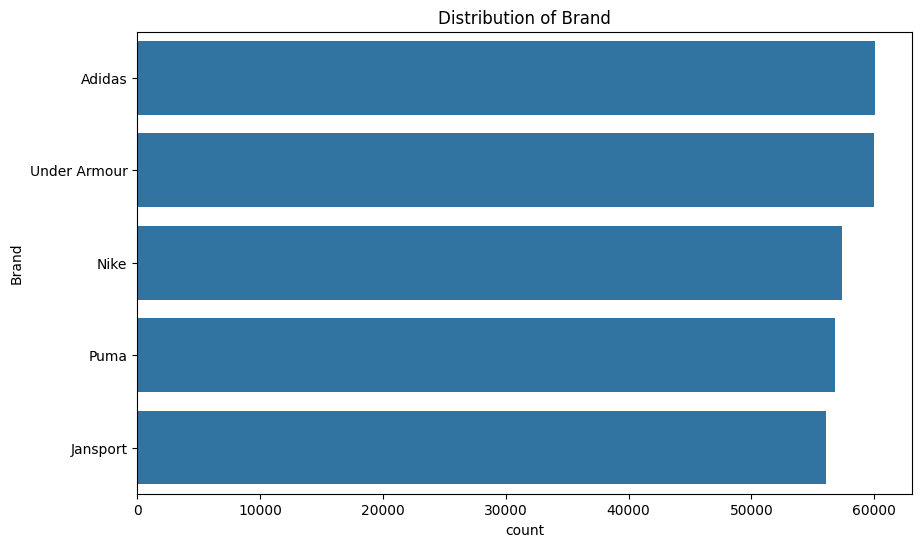

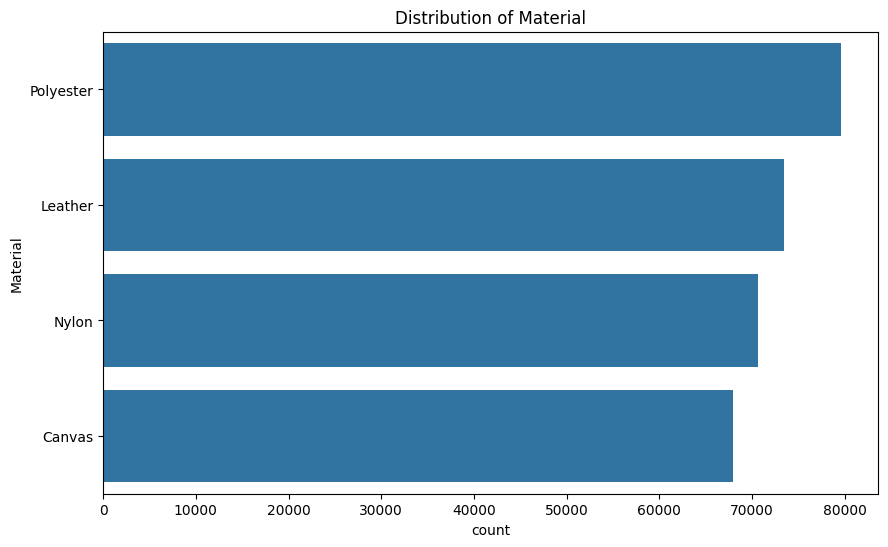

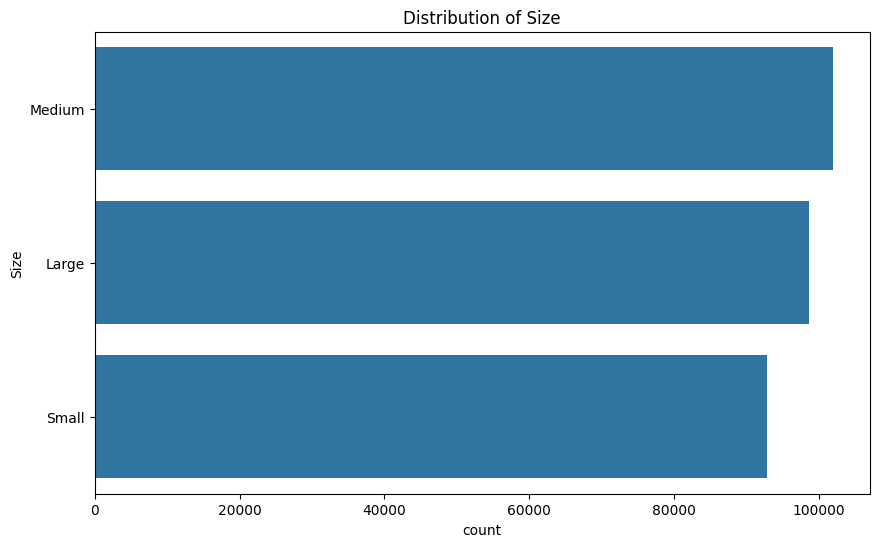

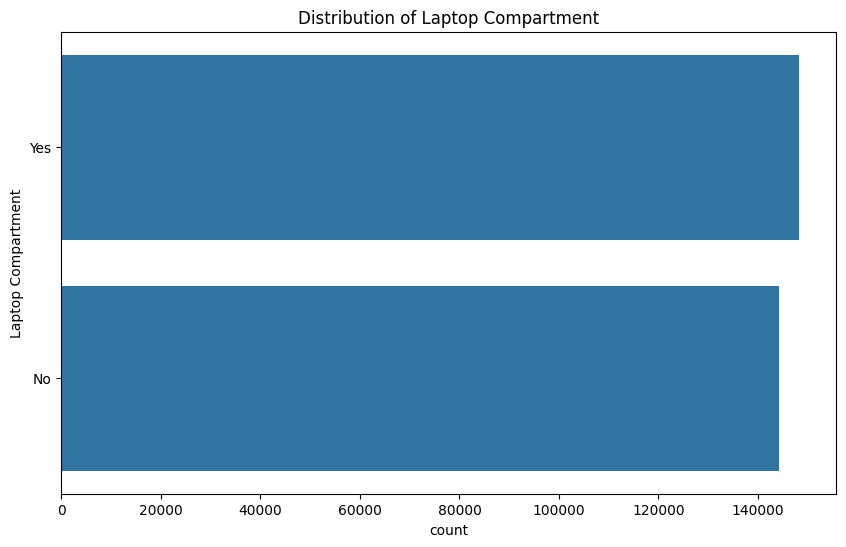

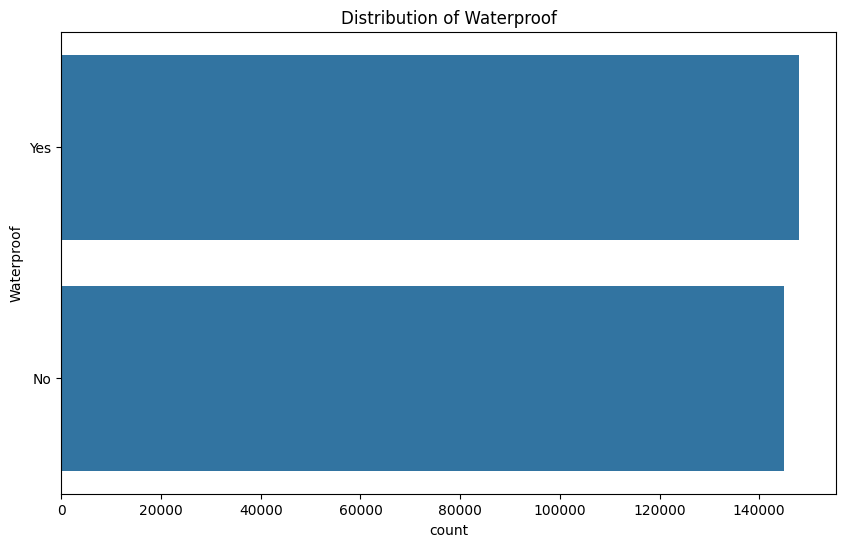

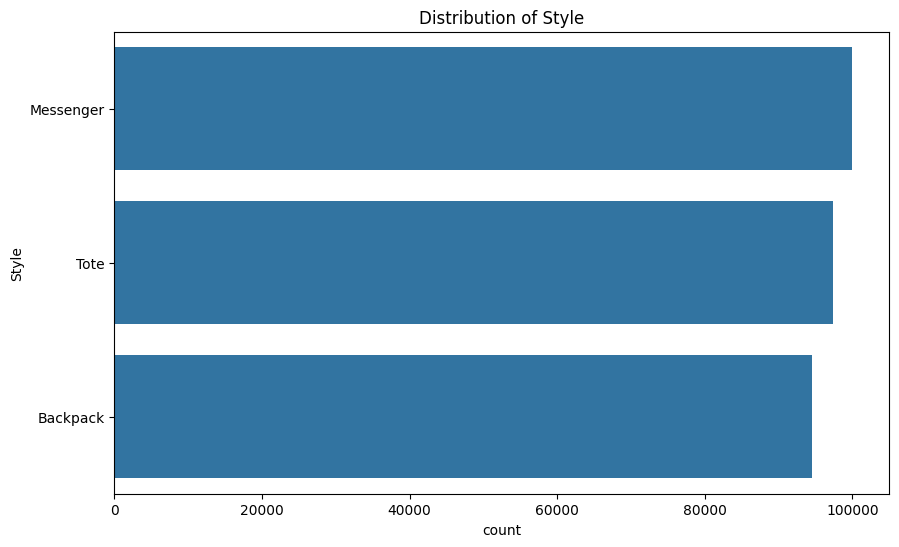

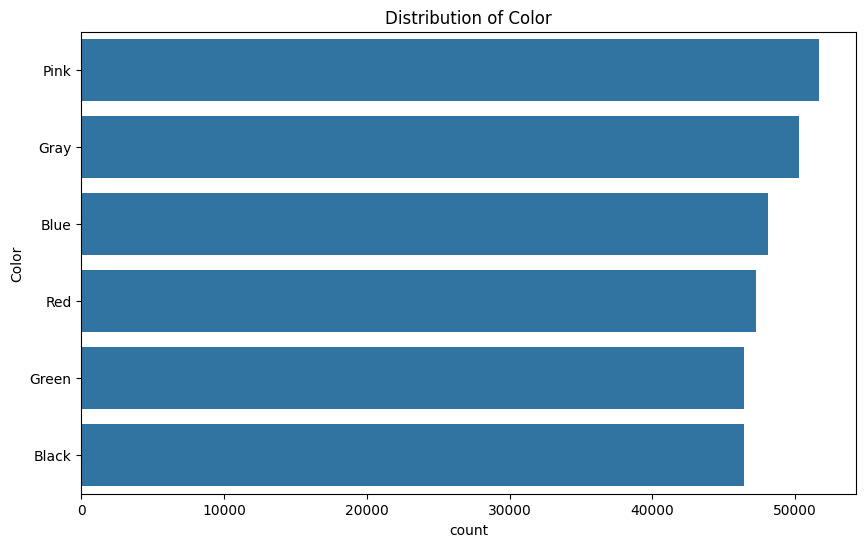

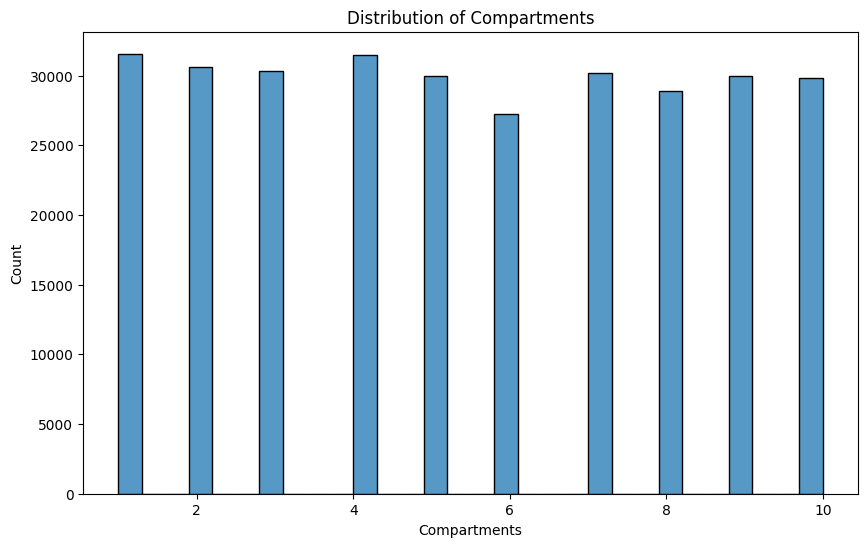

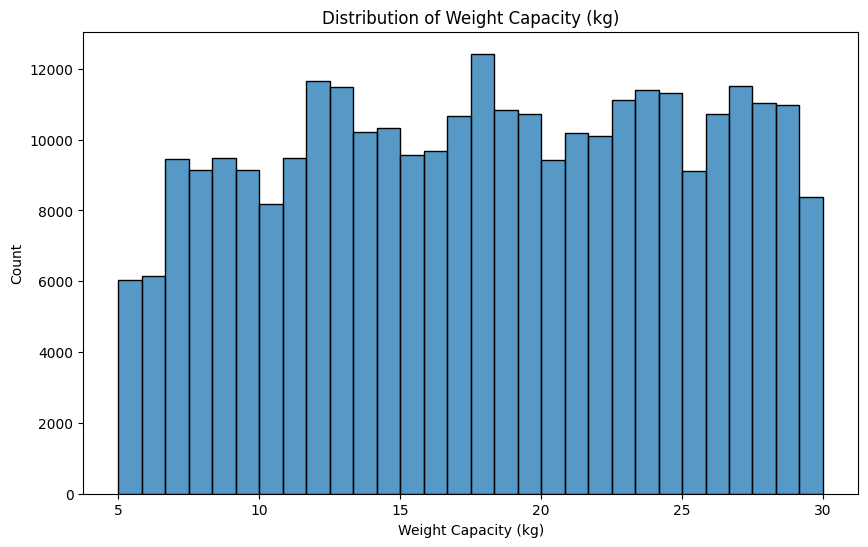

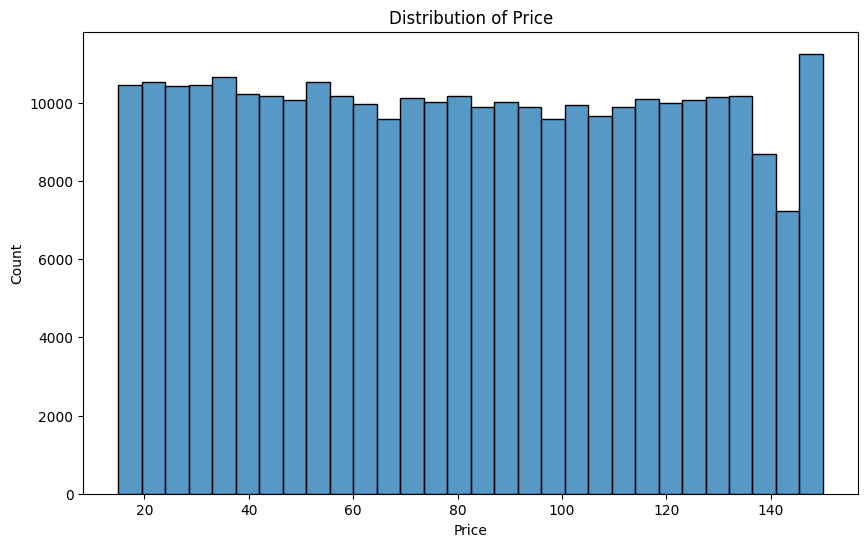

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

categorical_columns = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
numerical_columns = ['Compartments', 'Weight Capacity (kg)', 'Price']

def plot_categorical_columns(data, columns):
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(data[column], order=data[column].value_counts().index)
        plt.title(f"Distribution of {column}")
        plt.show()

def plot_numeric_columns(data, columns):
    for column in columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[column], bins=30)
        plt.title(f"Distribution of {column}")
        plt.show()

plot_categorical_columns(data, categorical_columns)
plot_numeric_columns(data, numerical_columns)


### Data Correlation

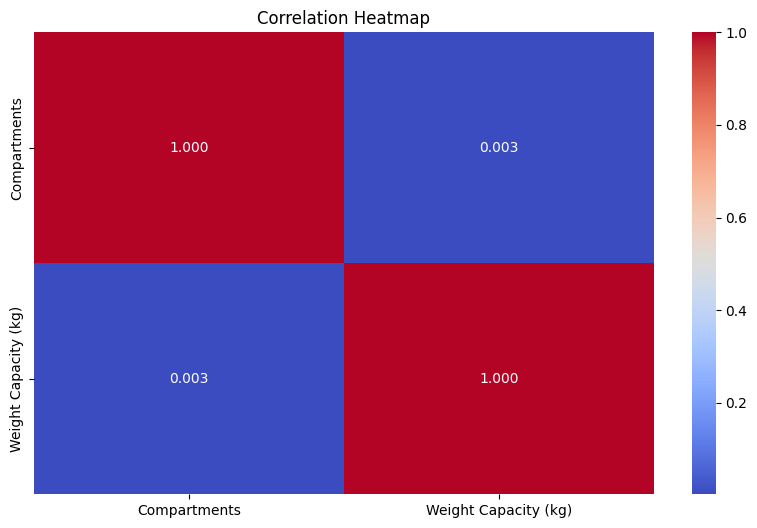

In [ ]:
%matplotlib inline

for i in range(len(categorical_columns)):
    for j in range(i + 1, len(categorical_columns)):
        plt.figure(figsize=(10, 6))
        sns.countplot(x=categorical_columns[i], hue=categorical_columns[j], data=data)
        plt.title(f"Countplot of {categorical_columns[i]} vs {categorical_columns[j]}")
        plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(data[[col for col in numerical_columns if col != 'Price']].corr(), annot=True, cmap='coolwarm', fmt=".3f")
plt.title(f"Correlation Heatmap")
plt.show()


# Data Preprocessing

### Data Imputation

In [14]:
def impute_data(df):
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    for col in numerical_columns:
        df[col] = df[col].fillna(df[col].median())

impute_data(data)

### Data Encoding

In [15]:
new_columns = ['IBrand', 'IMaterial', 'ISize', 'Has_Laptop_Compartment', 'Is_Waterproof', 'IStyle', 'IColor']

def encode_data(df):
    for col in ['Brand', 'Material', 'Style', 'Color']:
        df['I' + col] = df[col].astype('category').cat.codes

    df['ISize'] = df['Size'].map({'Small': 1, 'Medium': 2, 'Large': 3})

    df['Has_Laptop_Compartment'] = df['Laptop Compartment'].map({'Yes': 1, 'No': 0})
    df['Is_Waterproof'] = df['Waterproof'].map({'Yes': 1, 'No': 0})

encode_data(data)

### Data Normalization

In [16]:
new_columns += ['Weight_Capacity_Ratio']

def normalize_data(df):
    df['Weight_Capacity_Ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

normalize_data(data)

# Target Definition

In [17]:
final_columns = new_columns + ['Compartments']

X = data[final_columns]
y = data['Price']

print(X.head())
print(y.head())

   IBrand  IMaterial  ISize  Has_Laptop_Compartment  Is_Waterproof  IStyle  \
0       1          1      2                       1              0       2   
1       1          0      1                       1              1       1   
2       4          1      1                       1              0       1   
3       2          2      1                       1              0       1   
4       0          0      2                       1              1       1   

   IColor  Weight_Capacity_Ratio  Compartments  
0       0               0.387057           7.0  
1       3               0.902618          10.0  
2       5               0.554792           2.0  
3       3               0.431241           8.0  
4       3               0.591645           1.0  
0    112.15875
1     68.88056
2     39.17320
3     80.60793
4     86.02312
Name: Price, dtype: float64


___

## Model Building

### Decision Tree Regressors

In [18]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import math

model = DecisionTreeRegressor(random_state=1, max_depth=5)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mse = -cross_val_score(model, X, y, cv=10, scoring=mse_scorer)

print(f"Avg Root Mean Squared Error: {math.sqrt(np.mean(mse)):.2f}")
print(f"Min Root Mean Squared Error: {math.sqrt(np.min(mse)):.2f}")

Avg Root Mean Squared Error: 39.02
Min Root Mean Squared Error: 38.85


In [ ]:
from sklearn.tree import export_graphviz
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(100, 20))
plot_tree(model, filled=True, feature_names=X.columns, fontsize=10, max_depth=5)
plt.title("Decision Tree Visualization")
plt.show()


In [ ]:
# get all the values from hte Brand column
brand_values = train_data['Brand'].unique()
# get average price per brand
avg_price_per_brand = train_data.groupby('Brand')['Price'].mean().sort_values(ascending=False)
avg_price_per_brand
